This code illustrates the basic functionality of the component model using the data from this paper:

Norman-Haignere SV, Kanwisher NG, McDermott JH (2015). Distinct cortical pathways for music and speech revealed by hypothesis free voxel decomposition. Neuron.

In [614]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pyrsa

Load data from Neuron 2015 paper and return as a dataset, averaging across repetitions

In [329]:
MAT_file = '/Users/svnh2/Desktop/projects/naturalsound-analysis/data/simple_data_matrix_Neuron2015.mat'
D = io.loadmat(MAT_file, variable_names=['D'])['D']
D_average_reps = np.nanmean(D, axis=2)
dataset = pyrsa.data.Dataset(D_average_reps)

Plot dataset RDM

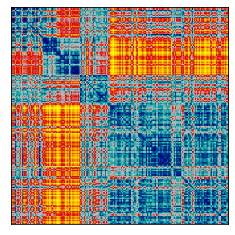

In [338]:
data_rdm = pyrsa.rdm.calc_rdm(dataset_natsound165)
pyrsa.vis.show_rdm(data_rdm, do_rank_transform=True)

Show RDM implied by all 6 components

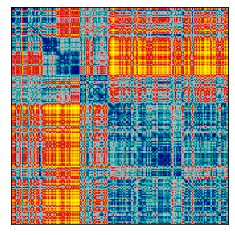

In [331]:
R = io.loadmat(MAT_file, variable_names=['R'])['R']
W = io.loadmat(MAT_file, variable_names=['W'])['W']
components = Components(R=R, W=W)
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(components.reconstruct()))
pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

Show RDM implied by single components

lowfreq


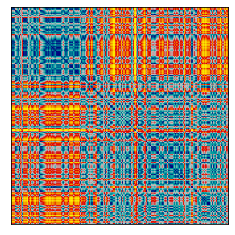

highfreq


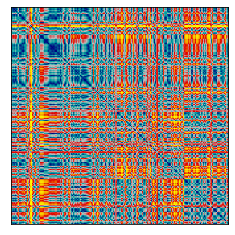

envsounds


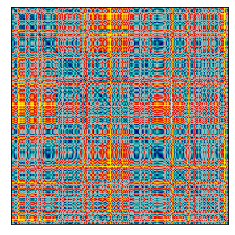

pitch


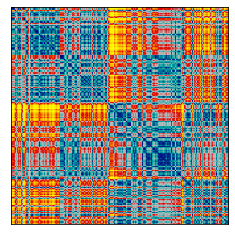

speech


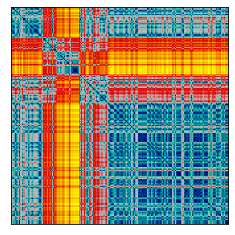

music


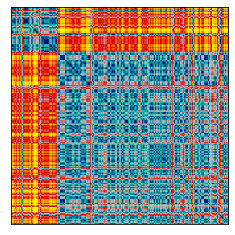

In [301]:
component_names = io.loadmat(MAT_file, variable_names=['component_names'])['component_names'][0].squeeze()

for i in range(len(component_names)):
    print(component_names[i][0])
    component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(components.reconstruct(subset=[i])))
    pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

Show primary and non-primary components

Primary


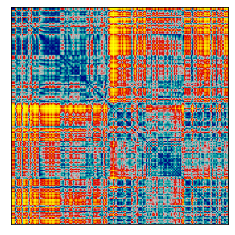

Nonprimary


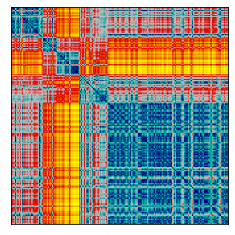

In [307]:
print('Primary')
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(components.reconstruct(subset=[0,1,3])))
pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

print('Nonprimary')
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(components.reconstruct(subset=[2,4,5]))) # with ambiguous C3
component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(components.reconstruct(subset=[4,5]))) # without ambiguous C3
pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

Show how RDM develops as you add PCs

Only need 3 PCs to capture RDMs, but 3 PCs misses a lot!

Dataset RDM


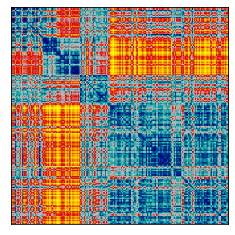

Number of PCs: 1


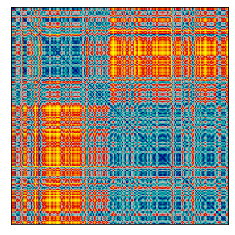

Number of PCs: 2


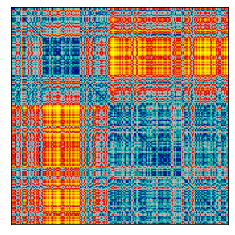

Number of PCs: 3


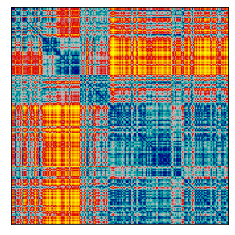

Number of PCs: 4


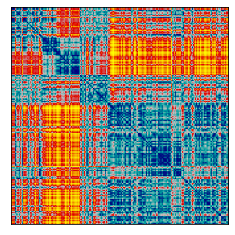

Number of PCs: 5


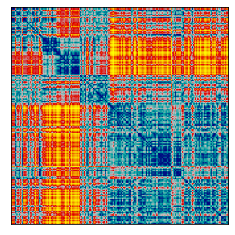

Number of PCs: 6


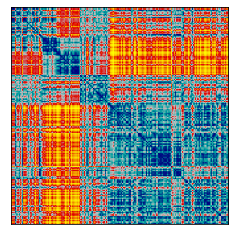

In [340]:
print('Dataset RDM')
data_rdm = pyrsa.rdm.calc_rdm(dataset_natsound165)
pyrsa.vis.show_rdm(data_rdm, do_rank_transform=True)

components.pca(dataset.measurements) # calculate principal components
for n_components in np.arange(1, 7):
    print('Number of PCs:', n_components)
    component_rdm = pyrsa.rdm.calc_rdm(pyrsa.data.Dataset(components.reconstruct(subset=np.arange(0, n_components)))) # without ambiguous C3
    pyrsa.vis.show_rdm(component_rdm, do_rank_transform=True)

Infer similar components with FastICA.

Method in the Neuron paper directly maximes entropy using a histogram-based method, which is suitable for fMRI where you have many voxels and can accurately estimate entropy for one-dimensional projections. FastICA uses a coarser approximation based on moments. Note that unlike PCA, ICA finds a local optimum and the results can thus depend upon the seed. Ideally, one runs the algorithm many times and tests whether the solutions with lowest cost all form a coherent solution.

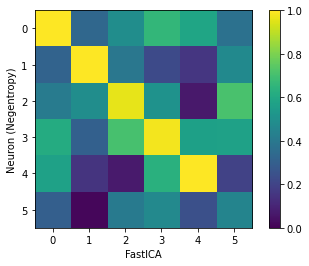

In [612]:
def corr_col_pairs(A, B):
    '''M x N correlation matrix'''
        
    corrmat = np.zeros((A.shape[1], B.shape[1]))
    for i in range(A.shape[1]):
        for j in range(B.shape[1]):
            corrmat[i,j] = np.corrcoef(A[:,i], B[:,j], rowvar=False)[0,1]
            
    return corrmat

def matching_order(ref_matrix, permute_matrix):
    '''Use Hungarian algorithm to match-up components.'''
    
    corrmat = corr_col_pairs(ref_matrix, permute_matrix)
    fixed_row_order, permuted_col_order = scipy.optimize.linear_sum_assignment(1-np.abs(corrmat))
    return permuted_col_order

# ICA components
fastica_components = Components()
random_seed = 0
fastica_components.fastica(dataset.measurements, n_components=6, method_params={'random_state': random_seed}) # calculate principal components

# Order components to best match neuron paper
neuron_components = Components(R=R, W=W)
optimal_order = matching_order(neuron_components.R, fastica_components.R)
fastica_components.order_components(optimal_order) 

# Compare
corrmat = corr_col_pairs(neuron_components.R, fastica_components.R)
plt.imshow(np.abs(corrmat), vmin=0, vmax=1)
plt.xlabel('FastICA')
plt.ylabel('Neuron (Negentropy)')
plt.colorbar()
plt.show()

PCA components are quite different because responses are forced to be orthogonal

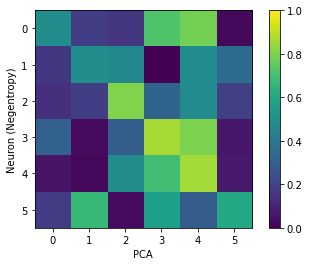

In [595]:
# PCA components
pca_components = Components()
pca_components.pca(dataset.measurements, n_components=6)

# Order components to best match neuron paper
neuron_components = Components(R=R, W=W)
optimal_order = matching_order(neuron_components.R, pca_components.R)
pca_components.order_components(optimal_order) 

# Compare
corrmat = corr_col_pairs(neuron_components.R, pca_components.R)
plt.imshow(np.abs(corrmat), vmin=0, vmax=1)
plt.xlabel('PCA')
plt.ylabel('Neuron (Negentropy)')
plt.colorbar()
plt.show()

In [547]:
class Components:
    def __init__(self, R=None, W=None):
        '''Returns an'''
        
        self.R = R
        self.W = W
        if self.R is not None:
            if self.R.shape[1] != self.W.shape[0]:
                raise NameError('Columns of R must match rows of W')
            self.n_components = R.shape[1]
        else:
            self.n_components = None
        
    def reconstruct(self, subset=None):
        '''
        Reconstructs data [stimuli x channels] by multiplying response and weight matrices.
        Can optionally select a subset of components.
        '''
        
        if subset is not None:
            measurements = np.matmul(self.R[:,subset], self.W[subset,:])
        else:
            measurements = np.matmul(self.R, self.W)
        return measurements
        
    def pca(self, measurements, n_components=None):        
        [U, s, Vh] = np.linalg.svd(measurements, full_matrices=False)
        self.R = U
        self.W = np.expand_dims(s, axis=1) * Vh
        self._select_topN(n_components)
            
    def fastica(self, measurements, n_components=None, method_params={}):
        ica = sklearn.decomposition.FastICA(n_components=n_components, **method_params)
        W_demeaned = ica.fit_transform(np.transpose(measurements))
        self.R = ica.mixing_
        self.W = np.matmul(np.linalg.pinv(self.R), measurements)
        self._select_topN(n_components)

    def _select_topN(self, n_components=None):
        if n_components is None:
            self.n_components = s.shape[0]
        else:
            self.R = self.R[:, :n_components]
            self.W = self.W[:n_components, :]
            self.n_components = n_components
            
    def order_components(self, order):
        self.R = self.R[:, order]
        self.W = self.W[order, :]
        